In [1]:
# Imports
import torch
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
#switching off autograd globally
torch.set_grad_enabled(False)

# 1. Modules

## Baseclass

In [3]:
class Module(object):

    """
    Base class for all modules.
    """

    def forward(self, input_):
        """
        Function to get the input, apply forward pass of module and
        returns a tensor or a tuple of tensors.
        """
        raise NotImplementedError

    def backward(self, gradswrtoutput):
        """
        Function to get input the gradient of the loss with respect to the
        module’s output, accumulate the gradient wrt the parameters, and
        return a tensor or a tuple of tensors containing the gradient of
        the loss wrt the module’s input.
        """
        raise NotImplementedError

    def param(self):
        """
        Returns a list of pairs, each composed of a parameter tensor, and
        a gradient tensor of same size.
        """
        return []

    def zero_grad(self):
        """
        Sets the gradients of a module to 0
        """
        return []

## Activation Functions

### TanH

In [4]:
class TanH(Module):

    """Module to apply the Hyperbolic Tangent function"""

    def __init__(self):

        super().__init__()
        self.name = "TanH"

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying tanh to the input

        Parameters:
            input (Tensor): The tensor on which the tanh should be applied

        Returns:
            Tensor: The tensor obtained after applying the tanh on the input
        """

        self.out_ = input_.tanh()

        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying tanh

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """

        return gradwrtoutput * (1 - self.out_.pow(2))

    def param(self):

        return []

### ReLU

In [5]:
class ReLU(Module):

    """Module to apply the Rectified Linear function"""

    def __init__(self):

        super().__init__()
        self.name = "ReLU"

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying ReLU to the input.

        Parameters:
            input (Tensor): The tensor on which the ReLU should be applied

        Returns:
            Tensor: The tensor obtained after applying the ReLU on the input
        """

        self.out = input_.clamp(min=0.0)

        return self.out

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying ReLU

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """

        self.out[self.out < 0] = 0
        self.out[self.out > 0] = 1

        return gradwrtoutput * self.out

    def param(self):

        return []

### Sigmoid

In [6]:
# did not require in the assignment

class Sigmoid(Module):

    """Module to apply the Sigmoid function"""

    def __init__(self):

        super().__init__()
        self.name = "Sigmoid"

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying sigmoid to the input.

        Parameters:
            input (Tensor): The tensor on which the sigmoid should be applied

        Returns:
            Tensor: The tensor obtained after applying the sigmoid on the input
        """

        self.out_ = input_.sigmoid()

        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying sigmoid

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """

        return gradwrtoutput * (self.out_ - self.out_**2)

    def param(self):

        return []

## Batch Norm

In [7]:
# did not require in the assignment

class BatchNorm(Module):

    """Module to apply the Batch Normalisation"""

    def __init__(self, eps: float = 0.000001):
        """
        Parameters:
            eps (float): The epsilon value to add to the denominator to avoid
            division by zero
        """

        super().__init__()
        self.name = "Batch Norm"
        self.eps = eps

        if self.eps < 0:
            raise ValueError("Epsilon {} should be greater than zero".format(
                self.eps))

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying Batch Norm to the input.

        Parameters:
            input_ (Tensor): The tensor on which the Batch Norm should be applied

        Returns:
            Tensor: The tensor obtained after applying the Batch Norm on the input
        """

        per_component_mean = input_.mean(dim=0)
        per_component_var = input_.var(dim=0)
        numer = input_ - per_component_mean
        denom = torch.sqrt(per_component_var.add(self.eps))
        self.out_ = numer/denom

        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of the previous layer as it is

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: same as input
        """

        return gradwrtoutput

    def param(self):

        return []

## Losses

### MSE

In [8]:
class MSELoss(Module):

    """Module to calculate the Mean Squared Error."""

    def __init__(self):
        super().__init__()
        self.name = "MSE Loss"

    def __str__(self):
        return self.name

    def forward(self, output_: torch.Tensor,
                target: torch.Tensor) -> torch.Tensor:
        """Returns the MSE Loss between output_ and target

        Parameters:
            output_ (Tensor): First tensor to calculate the MSE.
            target (Tensor): Second tensor to calculate the MSE.

        Returns:
            Tensor: The Mean Squared Loss between input_ and target
        """

        self.error = output_ - target
        self.loss = self.error.pow(2).mean()

        return self.loss

    def backward(self) -> torch.Tensor:
        """
        gradient of loss

        Returns:
            Tensor: The gradient of Mean Squared Loss between input_ and target
        """

        return (2 * self.error)/self.error.size()[0]

### Cross Entropy

In [9]:
class CrossEntropyLoss(Module):

    """Module to calculate the Cross Entropy Loss."""

    def __init__(self):
        super().__init__()
        self.name = "Cross Entropy Loss"

    def __str__(self):
        return self.name

    def softmax_(self, output_: torch.Tensor) -> torch.Tensor:
        """
        Applies and Returns the tensor after applying Softmax on the output_.
        To account for the underflow and the overflow of the values, we sutract
        each entry by the max value.

        Parameters:
            output_ (Tensor): First tensor to calculate the softmax probability.

        Returns:
            Tensor: The softmax of the output_.
        """

        diff_exp = (output_ - output_.max(1)[0].unsqueeze(1)).exp()

        return diff_exp / (diff_exp.sum(1).unsqueeze(1))

    def forward(self, output_: torch.Tensor,
                target: torch.Tensor) -> torch.Tensor:
        """
        Returns the Cross Entropy Loss (CEL) between output_ and target

        Parameters:
            output_ (Tensor): First tensor to calculate the CEL.
            target (Tensor): Second tensor to calculate the CEL.

        Returns:
            Tensor: The CEL between input_ and target
        """

        self.prob = self.softmax_(output_).log()
        self.logprob = self.prob.log()  # get log softmax probabilities
        self.classes = target
        self.loss = -(self.classes * self.prob).sum(1).mean()

        return self.loss

    def backward(self):
        """
        gradient of loss. 

        The mathematical derivation is reference from here
        http://machinelearningmechanic.com/deep_learning/2019/09/04/cross-entropy-loss-derivative.html#:~:text=Cross%2DEntropy%20Loss%20Function&text=When%20training%20the%20network%20with,computation%20in%20the%20backward%20pass.&text=This%20loss%20function%20is%20sometimes%20also%20referred%20to%20as%20the%20Softmax%20Classifier.

        Returns:
            Tensor: The gradient of Mean Squared Loss between input_ and target
        """

        return (self.prob-self.classes)

## Optimizer

In [10]:
class Optimizer(object):

    """
    Base class for optimzers.
    """

    def step(self):
        """
         Perform the single optimization step
        """

        raise NotImplementedError

### SGD

In [11]:
class SGD(Optimizer):

    """
    Module to perform Stochastic Gradient Descent
    """

    def __init__(self, params: list, lr=0.01):
        """
        Parameters
            params (list): List of the paramerters of the network
            lr (float): The learning rate of the network
        """

        super().__init__()
        self.name = "SGD"

        self.params = params
        self.lr = lr

        if self.lr <= 0.0:
            raise ValueError(
                "Learning rate {} should be greater than zero".format(self.lr))

    def __str__(self):
        return self.name

    def step(self):
        """
        Function to perform the single optimization step
        """

        for weight, gradient in self.params:
            if (weight is None) or (gradient is None):
                # incase of activation function modules, skip them
                continue
            else:
                weight.add_(-self.lr*gradient)

## Layers

### Linear 

In [12]:
class Linear(Module):

    """
    Module that implements as linear maxtrix operation layer
    """

    def __init__(self, in_features: int, out_features: int,
                 bias: bool = True, weightsinit: str = "normal"):
        """
        Initialises the layer by creating empty weight and bias tensors
        and Initialising them using Normal distribution.

        Parameters
            in_features (int): The size of each input sample
            out_features (int): The size of each output sample
            bias – If set to False, the layer will not learn an additive bias. Default: True
        """

        super().__init__()
        self.name = "Linear"

        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weightsinit = weightsinit

        self.w = torch.empty(self.in_features, self.out_features)
        self.gradw = torch.empty(self.in_features, self.out_features)

        if self.bias:
            self.b = torch.empty(self.out_features)
            self.gradb = torch.empty(self.out_features)
        else:
            self.b = None
            self.gradb = None

        self.initWeights()

    def __str__(self):
        return self.name

    def initWeights(self):
        """
        Initialises the weight and bias parameters of the layer depending on
        the weightinit parameter. Irrespective of the weightinit parameter
        the bias are always initialised using normal distribution

        If "weightsinit" is
            1. normal (by default), the weights are initiliased using normal distribution.
            2. xavier, the weights are initiliased using Xavier Initialization.
            3. kaiming, the weights are initiliased using Kaiming Initialization when using ReLU layer
        """

        if self.weightsinit == "normal":
            self.w.normal_()

        elif self.weightsinit == "xavier":
            self.w.normal_().mul_(math.sqrt(2/(self.in_features + self.out_features)))

        elif self.weightsinit == "kaiming":
            self.w.normal_().mul_(math.sqrt(2/(self.in_features)))

        self.gradw.fill_(0)

        if self.b is not None:
            self.b.normal_()
            self.gradb.fill_(0)

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """
        Computes the forward pass of the layer by multiplying the input with weights and adding the bias
        """

        self.inp = input_

        if self.b is None:
            self.output = self.inp.matmul(self.w)
        else:
            self.output = self.inp.matmul(self.w).add(self.b)

        return self.output

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        computes the gradient the weights and biases.
        """

        gradw = self.inp.t().matmul(gradwrtoutput)
        self.gradw.add_(gradw)

        if self.b is not None:
            gradb = gradwrtoutput.sum(0)
            self.gradb.add_(gradb)
        gradient = gradwrtoutput.matmul(self.w.t())

        return gradient

    def param(self) -> list:
        """
        Return the paramerters of the layer
        """

        params = [(self.w, self.gradw)]
        if self.b is not None:
            params.append((self.b, self.gradb))

        return params

    def zero_grad(self):
        """
        Sets the gradient to zero
        """

        self.gradw.zero_()

        if self.b is not None:
            self.gradb.zero_()

### Sequential

In [13]:
class Sequential(Module):
    """
    Module to hold the layers and build the Network
    """

    def __init__(self, *args):
        """
        Parameters
            *args (list[Module]): The list of modules to be constructed in the
            network.
        """
        super().__init__()
        self.name = "Sequential"

        # A list to hold all layers of the network
        self.modules = [module for module in args]

    def __str__(self):
        return self.name

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """
        Feed Forward prediction of the network. The input is propagated through
        all the layers and the output of the final layer is returned.

        Parameters
            input_ (Tensor): The input sample
        """
        self.inp = input_
        # incase of no layers, the input itself is returned as output
        output = input_

        for module in self.modules:
            output = module.forward(output)

        self.output = output

        return self.output

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Backward propagation of the network. The error is propagated through
        all the layers iteratively.

        Parameters
            input_ (Tensor): The input sample
        """
        # The error is propagated in the reverse (backward) direction
        for module in reversed(self.modules):
            gradwrtoutput = module.backward(gradwrtoutput)

#         self.grad = gradwrtoutput

#         return self.grad

    def param(self) -> list:
        """
        List of parameters of all modules

        Returns:
            params (list): List of tuple of weight and bias of each layer in
            the network
        """

        params = []
        for module in self.modules:
            params.extend(module.param())

        return params

    def zero_grad(self):
        """
        Sets the gradient to zero of all modules
        """

        for weight, gradient in self.param():
            if (weight is None) or (gradient is None):
                # incase of activation function modules, skip them
                continue
            else:
                gradient.zero_()

# 2. Data generation

In [14]:
def generate_data(num_points: int) -> [torch.Tensor, torch.Tensor]:
    """
    Function to generate the dataset of 1,000 points sampled uniformly
    in [0, 1]^2, each with a label 0 if outside the disk centered at (0.5; 0.5)
    of radius 1/sqrt(2*pi), and 1 inside.

    Parameters:
        num_points (int): The number of points to be generated

    Returns:
        Tensor : A two dimensional input data with points sampled between [0,1]
        Tensor : A two dimensional output data that contains labels
        corresponding to the input data generated above as one hot encoded variable
    """

    input_ = torch.Tensor(num_points, 2).uniform_(0, 1)

    labels = input_.sub(0.5).pow(2).sum(1).sub(1 / (2 * math.pi)).sign().add(1).div(2).long()

    labels_onehot = torch.empty(num_points, 2).fill_(0)
    labels_onehot[:, 0] = labels == 0
    labels_onehot[:, 1] = labels == 1

    return input_, labels_onehot

# 3. Train Model

In [15]:
def train_model(model: Sequential, train_input: torch.Tensor,
                train_target: torch.Tensor, loss_criteria: Module,
                learning_rate: float, mini_batch_size: int, nb_epochs: int
                ) -> list:
    """
    Function to train a model and return the epoch wise loss as a list.

    Parameters:
        model (Sequential): The neural network model
        train_input (Tensor): The input data samples
        train_target (Tensor): The target of data samples
        loss_criteria (Module): The loss function to use to train the model
        learning_rate (float): The learning rate to be update the weights of
        the model
        mini_batch_size (int): The batch size to train the model
        nb_epochs (int): The number of eppochs to train the network

    Returns:
        losses : A list of loss collected after each epoch of training
    """

    optimizer = SGD(model.param(), lr=learning_rate)
    losses = []
    for epoch_number in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            loss_ = loss_criteria.forward(
                output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            model.backward(loss_criteria.backward())
            optimizer.step()
        if epoch_number % 100 == 0:
            print("Epoch {} Training loss {}".format(
                epoch_number, loss_.item()))
        losses.append(loss_.item())
    return losses


def compute_nb_errors(model: Sequential, input_: torch.Tensor,
                      target: torch.Tensor) -> int:
    """
    Computes and returns the number of misclassifications by the model

    Parameters:
        model (Sequential): The neural network model
        input_ (Tensor): The input data samples
        target (Tensor): The target of data samples

    Returns
        nb_data_errors (int): The number of misclassifications.

    """

    nb_data_errors = 0

    output = model.forward(input_)

    _, predicted = torch.max(output.data, 1)

    _, actual = torch.max(target.data, 1)

    for k in range(input_.size()[0]):
        if actual.data[k] != predicted[k]:
            nb_data_errors = nb_data_errors + 1
    return nb_data_errors

# 4. Experiments

## Data Generation and Normalization

In [16]:
# generate the training and test samples

train_input, train_target = generate_data(1000)
test_input, test_target = generate_data(500)

# Normalising the train and test data
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

tensor([[-1.5710e+00, -6.6950e-01],
        [-3.7962e-01,  1.2452e+00],
        [-8.7082e-01,  8.5798e-01],
        [-7.9688e-01, -8.0648e-01],
        [ 1.0501e+00, -3.7127e-01],
        [ 6.3613e-01,  3.3219e-01],
        [ 1.3214e+00,  3.4827e-01],
        [-1.0830e+00,  8.3094e-01],
        [ 9.5305e-01, -7.8258e-01],
        [ 4.2167e-01, -1.7561e-01],
        [ 7.9961e-02, -1.2281e+00],
        [ 2.8961e-01,  1.4982e+00],
        [-4.1735e-01, -9.5966e-01],
        [-9.6350e-01,  9.4134e-01],
        [-5.7138e-01, -3.3060e-01],
        [-9.8053e-01, -7.4698e-02],
        [-9.0994e-01,  7.1424e-01],
        [ 9.4631e-01, -1.4357e+00],
        [-5.3516e-01,  1.1038e+00],
        [-2.4261e-01,  8.7878e-01],
        [ 5.6652e-01, -1.6706e+00],
        [ 1.7120e+00, -5.2220e-01],
        [ 9.9832e-01,  5.2814e-01],
        [ 5.1802e-01, -2.4841e-01],
        [ 1.5082e+00, -7.0741e-01],
        [ 1.3490e+00, -8.4181e-01],
        [-1.3173e+00, -1.0184e+00],
        [ 3.8390e-01,  8.870

## Models

We define the models to experiment with various parameters. All models will have a input, output layer and 3 hidden layer with 25 neurons each. The factors that can be used for experiments are: The type of activation, the type of loss, the type of weight initialisation and the usage of batch normalisation.

| **Model Number** | **Activation** | **Loss**      | **Batch Normalisation** | **Weight Initialisation** |
|:----------------:|:--------------:|:-------------:|:-----------------------:|:-------------------------:|
| 1                | TanH           | MSE           | No                      | Normal                    |
| 2                | TanH           | MSE           | No                      | Xavier                    |
| 3                | TanH           | MSE           | Yes                     | Normal                    |
| 4                | TanH           | MSE           | Yes                     | Xavier                    |
| 5                | TanH           | Cross Entropy | No                      | Normal                    |
| 6                | TanH           | Cross Entropy | No                      | Xavier                    |
| 7                | TanH           | Cross Entropy | Yes                     | Normal                    |
| 8                | TanH           | Cross Entropy | Yes                     | Xavier                    |
| 9                | ReLU           | MSE           | No                      | Normal                    |
| 10               | ReLU           | MSE           | No                      | kaiming                   |
| 12               | ReLU           | MSE           | Yes                     | Normal                    |
| 12               | ReLU           | MSE           | Yes                     | kaiming                   |
| 13               | ReLU           | Cross Entropy | No                      | Normal                    |
| 14               | ReLU           | Cross Entropy | No                      | kaiming                   |
| 15               | ReLU           | Cross Entropy | Yes                     | Normal                    |
| 16               | ReLU           | Cross Entropy | Yes                     | kaiming                   |


In [17]:
Model_1 = Sequential(Linear(2, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 2), Sigmoid())

Model_2 = Sequential(Linear(2, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 2, weightsinit="xavier"), Sigmoid())

Model_3 = Sequential(Linear(2, 25), TanH(), BatchNorm(),
                     Linear(25, 25), TanH(), BatchNorm(),
                     Linear(25, 25), TanH(), BatchNorm(),
                     Linear(25, 25), TanH(), BatchNorm(),
                     Linear(25, 2), Sigmoid())

Model_4 = Sequential(Linear(2, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 2, weightsinit="xavier"), Sigmoid())

Model_5 = Sequential(Linear(2, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 2))

Model_6 = Sequential(Linear(2, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 25, weightsinit="xavier"), TanH(),
                     Linear(25, 2, weightsinit="xavier"))

Model_7 = Sequential(Linear(2, 25), TanH(), BatchNorm(),
                     Linear(25, 25), TanH(), BatchNorm(),
                     Linear(25, 25), TanH(), BatchNorm(),
                     Linear(25, 25), TanH(), BatchNorm(),
                     Linear(25, 2))

Model_8 = Sequential(Linear(2, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 25, weightsinit="xavier"), TanH(), BatchNorm(),
                     Linear(25, 2, weightsinit="xavier"))

Model_9 = Sequential(Linear(2, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 2), Sigmoid())

Model_10 = Sequential(Linear(2, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 2, weightsinit="kaiming"), Sigmoid())

Model_11 = Sequential(Linear(2, 25), ReLU(), BatchNorm(),
                      Linear(25, 25), ReLU(), BatchNorm(),
                      Linear(25, 25), ReLU(), BatchNorm(),
                      Linear(25, 25), ReLU(), BatchNorm(),
                      Linear(25, 2), Sigmoid())

Model_12 = Sequential(Linear(2, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 2, weightsinit="kaiming"), Sigmoid())

Model_13 = Sequential(Linear(2, 25), ReLU(),
                      Linear(25, 25), ReLU(),
                      Linear(25, 25), ReLU(),
                      Linear(25, 25), ReLU(),
                      Linear(25, 2))

Model_14 = Sequential(Linear(2, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(),
                      Linear(25, 2, weightsinit="kaiming"))

Model_15 = Sequential(Linear(2, 25), ReLU(), BatchNorm(),
                      Linear(25, 25), ReLU(), BatchNorm(),
                      Linear(25, 25), ReLU(), BatchNorm(),
                      Linear(25, 25), ReLU(), BatchNorm(),
                      Linear(25, 2))

Model_16 = Sequential(Linear(2, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 25, weightsinit="kaiming"), ReLU(), BatchNorm(),
                      Linear(25, 2, weightsinit="kaiming"))

In [18]:
mseloss = MSELoss()
celoss = CrossEntropyLoss()

In [19]:
models = {1: {"model": Model_1, "activation": "TanH", "loss": mseloss,
              "BatchNorm": "NO", "weightint": "Normal"},
          2: {"model": Model_2, "activation": "TanH", "loss": mseloss,
              "BatchNorm": "NO", "weightint": "Xavier"},
          3: {"model": Model_3, "activation": "TanH", "loss": mseloss,
              "BatchNorm": "YES", "weightint": "Normal"},
          4: {"model": Model_4, "activation": "TanH", "loss": mseloss,
              "BatchNorm": "YES", "weightint": "Xavier"},
          5: {"model": Model_5, "activation": "TanH", "loss": celoss,
              "BatchNorm": "NO", "weightint": "Normal"},
          6: {"model": Model_6, "activation": "TanH", "loss": celoss,
              "BatchNorm": "NO", "weightint": "Xavier"},
          7: {"model": Model_7, "activation": "TanH", "loss": celoss,
              "BatchNorm": "YES", "weightint": "Normal"},
          8: {"model": Model_8, "activation": "TanH", "loss": celoss,
              "BatchNorm": "YES", "weightint": "Xavier"},
          9: {"model": Model_9, "activation": "ReLU", "loss": mseloss,
              "BatchNorm": "NO", "weightint": "Normal"},
          10: {"model": Model_10, "activation": "ReLU", "loss": mseloss,
               "BatchNorm": "NO", "weightint": "kaiming"},
          11: {"model": Model_11, "activation": "ReLU", "loss": mseloss,
               "BatchNorm": "YES", "weightint": "Normal"},
          12: {"model": Model_12, "activation": "ReLU", "loss": mseloss,
               "BatchNorm": "YES", "weightint": "kaiming"},
          13: {"model": Model_13, "activation": "ReLU", "loss": celoss,
               "BatchNorm": "NO", "weightint": "Normal"},
          14: {"model": Model_14, "activation": "ReLU", "loss": celoss,
               "BatchNorm": "NO", "weightint": "kaiming"},
          15: {"model": Model_15, "activation": "ReLU", "loss": celoss,
               "BatchNorm": "YES", "weightint": "Normal"},
          16: {"model": Model_16, "activation": "ReLU", "loss": celoss,
               "BatchNorm": "YES", "weightint": "kaiming"}}

In [20]:
learning_rate = 0.01
nb_epochs = 1000
model_result_attributes = {}
mini_batch_size = 100

for id_num, M in models.items():
    print("Model {} with {} activation, with {} weight initialisation and {} and Batch Norm is {}".format(id_num, M["activation"], M["weightint"], str(M["loss"]), M["BatchNorm"]))

    model = M["model"]

    model_loss = train_model(model, train_input, train_target, M["loss"],
                             learning_rate, mini_batch_size, nb_epochs)

    nb_train_errors = compute_nb_errors(model, train_input, train_target)
    nb_test_errors = compute_nb_errors(model, test_input, test_target)

    train_accuracy = (100 * (
        train_input.size(0)-nb_train_errors)) / train_input.size(0)

    test_accuracy = (100 * (
        test_input.size(0) - nb_test_errors)) / test_input.size(0)

    train_error = 100 - train_accuracy
    test_error = 100 - test_accuracy

    model_result_attributes[id_num] = {"epoch_loss": model_loss,
                                       "train_accuracy": train_accuracy,
                                       "train_error": test_accuracy,
                                       "test_accuracy": train_error,
                                       "test_error": test_error}

    print(
        'Train Accuracy {:0.2f}% {:d}/{:d}'.format(
            train_accuracy, (train_input.size(0) - nb_train_errors),
            train_input.size(0)))

    print(
        'Test Accuracy {:0.2f}% {:d}/{:d}'.format(
            test_accuracy, (test_input.size(0) - nb_test_errors),
            test_input.size(0)))

    print(
        'Train Error {:0.2f}% {:d}/{:d}'.format(
            train_error, nb_train_errors, train_input.size(0)))

    print('Test Error {:0.2f}% {:d}/{:d}'.format(
        test_error, nb_test_errors, test_input.size(0)))

    print("\n")

Model 1 with TanH activation, with Normal weight initialisation and MSE Loss Loss and Batch Norm is NO
Train Accuracy 100.00% 1000/1000
Test Accuracy 99.00% 495/500
Train Error 0.00% 0/1000
Test Error 1.00% 5/500


Model 2 with TanH activation, with Xavier weight initialisation and MSE Loss Loss and Batch Norm is NO
Train Accuracy 99.80% 998/1000
Test Accuracy 99.20% 496/500
Train Error 0.20% 2/1000
Test Error 0.80% 4/500


Model 3 with TanH activation, with Normal weight initialisation and MSE Loss Loss and Batch Norm is YES
Train Accuracy 96.70% 967/1000
Test Accuracy 96.00% 480/500
Train Error 3.30% 33/1000
Test Error 4.00% 20/500


Model 4 with TanH activation, with Xavier weight initialisation and MSE Loss Loss and Batch Norm is YES
Train Accuracy 98.50% 985/1000
Test Accuracy 97.60% 488/500
Train Error 1.50% 15/1000
Test Error 2.40% 12/500


Model 5 with TanH activation, with Normal weight initialisation and Cross Entropy Loss Loss and Batch Norm is NO
Train Accuracy 52.00% 520/1

# 4. Plotting Loss

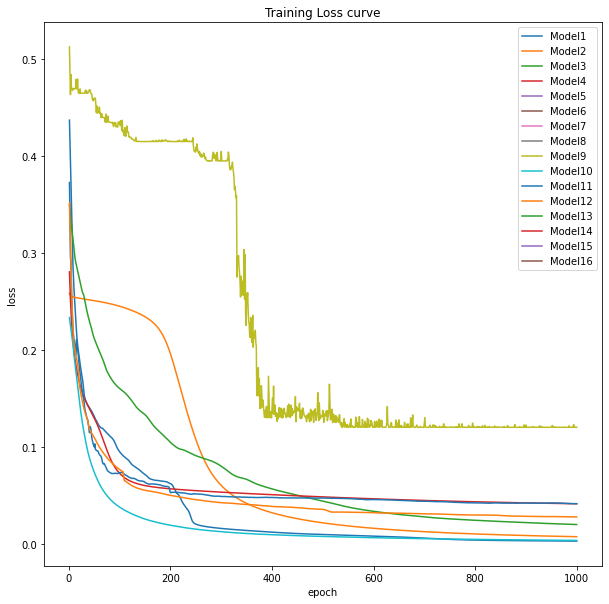

In [23]:
epochs = range(1, nb_epochs+1)

for mnum, mattr in model_result_attributes.items():
    plt.plot(epochs, mattr["epoch_loss"], label="Model" + str(mnum))

plt.title("Training Loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

# ToDo

1. Check why ReLU is not working in certain conditions.
2. The result with cross entropy loss, ReLU are very bad. Debug the coding errors or check if we need to apply Sigmoid.
3. Plot the graphs based on criteria of Loss type, Activation Function, Batch Norm and Weight Initialisation type
4. Table the train and test accuracies and errors.
5. If easy, add option to use GPU
6. Write the conclusions we draw from the results.